In [1]:
!pip install tf-agents


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import random

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import zipfile
import tensorflow_probability as tfp

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.networks import network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.distributions.utils import SquashToSpecNormal
from tf_agents.networks import normal_projection_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import policy_saver
from tf_agents.specs import tensor_spec
from tf_agents.agents.sac import tanh_normal_projection_network

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent


tf.compat.v1.enable_v2_behavior()

import os
import shutil

try:
  from google.colab import files
except ImportError:
  files = None


from google.colab import drive 
drive.mount('/content/gdrive') 

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())


%xmode Verbose

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Exception reporting mode: Verbose


In [3]:
# use "num_iterations = 1e6" for better results,
# 1e5 is just so this doesn't take too long. 
num_iterations =  1000# @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (100, 100, 100)
critic_joint_fc_layer_params = (100, 100, 100)

log_interval =  1000# @param {type:"integer"}

num_eval_episodes =  10# @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}



In [4]:
_RHO = 0
def angular_reward(rho):
  return (lambda x, y: np.cos(rho) * x + np.sin(rho) * y)
def reward_fun(self, other):
  f = angular_reward(_RHO)
  return f(self, other)

def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()


In [5]:

def construct_agent(observation_spec, action_spec, time_step_spec):
  agent_array_action_spec = action_spec
  agent_array_observation_spec = observation_spec

  agent_action_spec = tensor_spec.from_spec(agent_array_action_spec)
  agent_observation_spec = tensor_spec.from_spec(agent_array_observation_spec)


  critic_net = critic_network.CriticNetwork(
    (agent_observation_spec, agent_action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)


  actor_net = actor_distribution_network.ActorDistributionNetwork(
    agent_observation_spec,
    agent_action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=tanh_normal_projection_network
        .TanhNormalProjectionNetwork
    )

  value_net = value_network.ValueNetwork(observation_spec)

  global_step = tf.compat.v1.train.get_or_create_global_step()

  tf_agent = sac_agent.SacAgent(
      time_step_spec,
      agent_action_spec,
      actor_network=actor_net,
      critic_network=critic_net,
      actor_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=actor_learning_rate),
      critic_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=critic_learning_rate),
      alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=alpha_learning_rate),
      target_update_tau=target_update_tau,
      target_update_period=target_update_period,
      td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
      gamma=gamma,
      reward_scale_factor=reward_scale_factor,
      gradient_clipping=gradient_clipping,
      train_step_counter=global_step)
  tf_agent.initialize()
  return tf_agent





In [6]:
class PublicGoodsEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.float32, minimum=0, maximum = 1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(11,2), dtype=np.float32, name='observation')
    s = np.full((11, 2), -1, dtype=np.float32)
    self._state = s
    self._episode_ended = False
    self._counter = 0
    self._END = 10
    self._MULT = 1.5


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    s = np.full((11, 2), -1, dtype=np.float32)
    self._state = s
    self._episode_ended = False
    self._counter = 0
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):
    self._counter += 1

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()
    
    self._state[self._counter - 1, 0] = action[0]
    self._state[self._counter - 1, 1] = action[1]

    # Make sure episodes don't go on forever.
    if self._counter > self._END:
      self._episode_ended = True

    s1 = 1
    a1 = self._state[self._counter - 1, 0] * s1
    s2 = 1
    a2 = self._state[self._counter - 1, 1] * s2
    s1_final = s1 - a1 + (a1 + a2)*self._MULT / 2
    s2_final = s2 - a2 + (a1 + a2)*self._MULT / 2

    if self._episode_ended:
      reward_self = s1_final - s1
      reward_other = s2_final - s2
      my_reward = reward_fun(reward_self, reward_other)

      ret = ts.termination(np.array(self._state, dtype=np.float32), my_reward)
      self._counter += 1

      return ret
    else:
      reward_self = s1_final - s1
      reward_other = s2_final - s2
      my_reward = reward_fun(reward_self, reward_other)
      ret = ts.transition(
          np.array(self._state, dtype=np.float32), reward=my_reward, discount=1.0)
      #print("transition:", ret)
      return ret

def create_env():
  return tf_py_environment.TFPyEnvironment(PublicGoodsEnv())

def validate_random(environment, episodes):
  time_step_spec = environment.time_step_spec()
  action_spec = environment.action_spec()

  episode_count = 0
  time_step = environment.reset()

  while episode_count < episodes:
    if not array_spec.check_arrays_nest(time_step, time_step_spec):
      raise ValueError(
          'Given `time_step`: %r does not match expected `time_step_spec`: %r' %
          (time_step, time_step_spec))
    obs = time_step.observation
    action0 = [random.uniform(0, 1)]
    action1 = [random.uniform(0, 1)]

    new_action = [action0[0], action1[0]]
    time_step = environment.step(new_action)
    print(time_step)

    if time_step.is_last():
        episode_count += 1
        time_step = environment.reset()



In [7]:
def make_checkpoint(tf_agent, train_env):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)
  train_checkpointer = common.Checkpointer(
      ckpt_dir=os.path.join(tempdir, 'checkpoint'),
      max_to_keep=1,
      agent=tf_agent,
      policy=tf_agent.policy,
      replay_buffer=replay_buffer,
      global_step=tf_agent.train_step_counter
  )

  """rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(tempdir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)"""
  #rb_checkpointer.save()
  return train_checkpointer, None


In [8]:
def self_play_train(rho, tf_agent, train_env, eval_env, train_checkpointer, rb_checkpointer):
  _RHO = rho
  def construct_intended_action(policy0, policy1, time_step, print_bool):
    action_step0 = policy0.action(time_step) 
    if action_step0.action.numpy() < 0 or action_step0.action.numpy() > 1:
      print("WARNING OUT OF SPEC")

    obs = time_step.observation.numpy()[0]
    r, _ = np.shape(obs)
    for i in range(r):
      my_obs = obs[i]
      obs[i] = [my_obs[1], my_obs[0]]
    obs = tf.convert_to_tensor(np.array(obs, dtype=np.float32))

    step_type = time_step.step_type.numpy()[0]
    step_type = tf.constant(step_type, dtype=tf.int32)      

    reward = time_step.reward.numpy()[0]
    reward = tf.constant(reward, dtype=tf.float32)    

    discount = time_step.discount.numpy()[0]
    discount = tf.constant(discount, dtype=tf.float32)

    time_step = ts.TimeStep(step_type, reward, discount, obs)
    #print("time step edited", time_step)
    action_step1 = policy1.action(time_step)

    action0 = action_step0.action.numpy()[0]
    action1 = action_step1.action.numpy()
    if print_bool:
      print(action0)
      print(action1)

    new_action = tf.convert_to_tensor(np.array([[action0[0], action1[0]]], dtype=np.float32))
    return new_action
  
  def compute_avg_return(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action = construct_intended_action(policy0, policy1, time_step, False)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]



  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)
  """rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(tempdir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)"""
  
  """upload_and_unzip_file_to(os.path.join(tempdir, 'replay_buffer'))
  rb_checkpointer.initialize_or_restore()"""
  
  def collect_step(environment, policy0, policy1):

    time_step = environment.current_time_step()

    new_action = construct_intended_action(policy0, policy1, time_step, False)

    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

  def collect_data(env, policy0, policy1, steps):
    for _ in range(steps):
      collect_step(env, policy0, policy1)

  collect_data(train_env, tf_agent.collect_policy, tf_agent.collect_policy, steps=100)

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

  iterator = iter(dataset)

  
  
  try:
    %%time
  except:
    pass

  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  tf_agent.train = common.function(tf_agent.train)

  # Reset the train step
  tf_agent.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
  returns = [avg_return]

  for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
      collect_step(train_env, tf_agent.collect_policy, tf_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.

    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)


  steps = range(0, num_iterations + 1, eval_interval)
  plt.plot(steps, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Step')
  plt.ylim(top=5.5)

  train_checkpointer.save(tf_agent.train_step_counter.numpy())
  #rb_checkpointer.save(global_step)
  



In [9]:
def save_checkpoint(fname, train_checkpointer, rb_checkpointer):
  checkpoint_zip_filename = create_zip_file(os.path.join(tempdir, 'checkpoint'), os.path.join(tempdir, fname + '-cp'))
  #rb_checkpoint_zip_filename = create_zip_file(os.path.join(tempdir, 'replay_buffer'), os.path.join(tempdir, fname + '-rb'))
  %pwd
  os.mkdir("gdrive/My Drive/colab+git/"+fname+"-cp")

  shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-cp")
  #shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-rb")



In [ ]:
def league(fnames)

In [10]:
env = create_env()
action_spec = array_spec.BoundedArraySpec(
    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
tf_agent = construct_agent(env.observation_spec(), action_spec, env.time_step_spec())
tc, rc = make_checkpoint(tf_agent, env)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


step = 1000: loss = -0.8836631774902344
step = 1000: Average Return = 3.0939764976501465


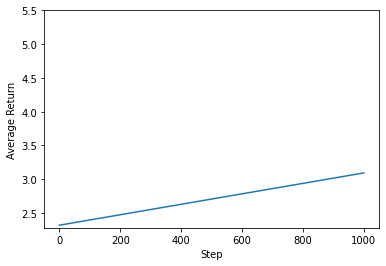

In [11]:
self_play_train(0, tf_agent, env, create_env(), tc, rc)

In [12]:
save_checkpoint("svo-0-test", tc, rc)
